[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total documents: 2000

Classification Report:
              precision    recall  f1-score   support

         neg       0.83      0.82      0.82       206
         pos       0.81      0.82      0.82       194

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400

Accuracy: 0.8200


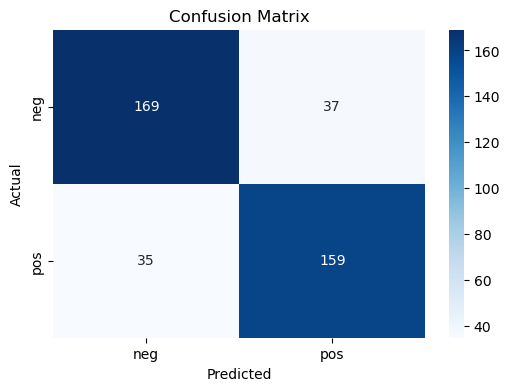

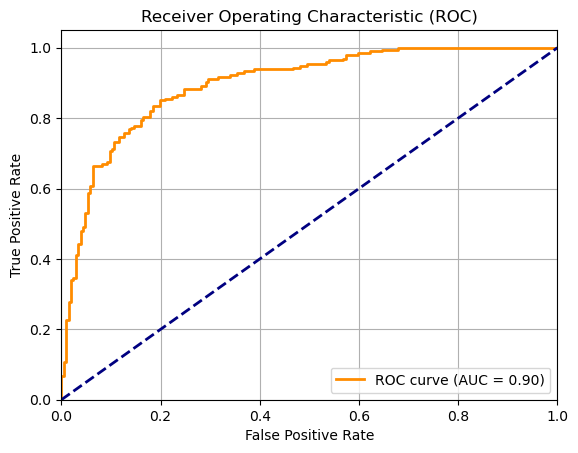

In [1]:
# ================== IMPORT LIBRARIES ==================
import nltk
import random
import string
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK components
from nltk.corpus import movie_reviews, stopwords
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer

# Scikit-learn components
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ================== DOWNLOAD NLTK DATA ==================
# Mengunduh resource yang dibutuhkan dari NLTK
nltk.download('movie_reviews')
nltk.download('punkt')  # optional, tidak digunakan karena tokenizer diganti
nltk.download('stopwords')

# ================== TEXT PREPROCESSING FUNCTION ==================
# Inisialisasi stopwords, stemmer, dan tokenizer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
tokenizer = TreebankWordTokenizer()

# Fungsi preprocessing: lowercase, tokenisasi, hapus stopwords, stemming
def preprocess(text):
    tokens = tokenizer.tokenize(text.lower())                       # lowercase & tokenisasi
    tokens = [w for w in tokens if w.isalpha() and w not in stop_words]  # hapus non-alfabet & stopword
    stemmed = [stemmer.stem(w) for w in tokens]                     # stemming kata
    return ' '.join(stemmed)                                        # gabungkan kembali jadi string

# ================== LOAD DATASET ==================
# Ambil data dari NLTK corpus: (teks, label)
documents = [(movie_reviews.raw(fileid), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

# Acak dokumen agar sebaran label seimbang
random.shuffle(documents)

# Pisahkan teks dan label, lalu preprocessing teks
texts = [preprocess(text) for (text, label) in documents]
labels = [label for (text, label) in documents]

print(f'Total documents: {len(texts)}')

# ================== SPLIT DATA ==================
# Membagi data menjadi train (80%) dan test (20%)
texts_train, texts_test, labels_train, labels_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42)

# ================== TF-IDF VECTORIZATION ==================
# Ubah teks menjadi vektor angka berdasarkan frekuensi kata
vectorizer = TfidfVectorizer(max_features=3000)
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

# ================== TRAINING LOGISTIC REGRESSION ==================
# Inisialisasi dan latih model klasifikasi
model = LogisticRegression(max_iter=1000)
model.fit(X_train, labels_train)

# ================== PREDIKSI & EVALUASI ==================
# Prediksi pada data test
labels_pred = model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(labels_test, labels_pred)

# Classification report
print("\nClassification Report:")
print(classification_report(labels_test, labels_pred))

# Akurasi model
print(f'Accuracy: {accuracy_score(labels_test, labels_pred):.4f}')

# ================== VISUALISASI CONFUSION MATRIX ==================
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Tampilkan confusion matrix
plot_confusion_matrix(cm, model.classes_)

# ================== VISUALISASI ROC CURVE ==================
def plot_roc_curve(model, X_test, y_test, class_labels):
    # Binarisasi label ('pos', 'neg') menjadi 0 dan 1
    y_test_bin = label_binarize(y_test, classes=class_labels)
    # Probabilitas hasil prediksi (kolom untuk kelas positif)
    y_score = model.predict_proba(X_test)[:, 1]
    # Hitung FPR dan TPR
    fpr, tpr, _ = roc_curve(y_test_bin, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Tampilkan ROC curve
plot_roc_curve(model, X_test, labels_test, model.classes_)
